In [92]:
import pandas as pd

df = pd.read_csv('~/Dropbox/data_science/dataset/Kaggle/titanic/train.csv')
df = df.drop('Cabin', axis=1)
df = df.dropna()

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ipywidgets import widgets, HBox
from IPython.display import clear_output, display
from IPython import __version__ as ipython_version

old_IPython = ['5.3.0']

#%matplotlib inline -- needs to be ran in jupyter notebook browser


class Chart():
    
    '''
    
    Chart : creates an interactive chart of your data.
        Ex: chart = Chart(df), where df is a Pandas DataFrame
    
    df : DataFrame to create an interactive chart from.
    
    x : string of x variable from df or None (starting x variable)
    
    y : string of x variable from df (starting y variable)
    
    z : string of x variable from df or None (starting z variable)
    
    chart_type : string of starting chart, e.g. 'bar'
    
    
    Chart Properties:
    
    round : integer to round values by (accepts negatives).
        Ex: chart.round = 2
            chart.round = 3
            chart.round = -1
           
    title : string for chart title or None.
        Ex: chart.title = 'Species Sepal Length'
        Ex: chart.title = None

    xlabel : string for xlabel or None to show x variable.
        Ex: chart.xlabel = 'Species'
        Ex: chart.xlabel = None
    
    ylabel : string for ylabel or None to show y variable.
        Ex: chart.ylabel = 'Sepal Length'
        Ex: chart.ylabel = None

    ylim : list for y limit min and max or None.
        Ex: chart.ylim = [0, 10]
        Ex: chart.ylim = None        

    n_counts : boolean to show x-axis n counts.
        Ex: chart.n_counts = True
        Ex: chart.n_counts = False
        
    width : integer for plot width
        Ex: chart.width = 15
        
    height : integer for plot height
        Ex: chart.height = 6        
        
    num_format = 'f' for numeric or '%' for percentages.
        Ex: chart.num_format = 'f'
        Ex: chart.num_format = '%'
        
    labels : boolean to show value labels.
        Ex: chart.labels = True
        Ex: chart.labels = False

    font_size_multiple : float to change font size. Choose 
    between .5 (small) and 3 (large)
        Ex: chart.font_size_multiple = 1.3
        
                        
    '''
    
##  init  ##################################################

    def __init__(self, df, x=None, y=None, z=None, chart_type='bar'):
        
        # public attributes
        self.df = df.copy()
        self.x, self.y, self.z = x, y, z
        if self.y is None:
            self.y = self.df.select_dtypes(include=[np.number]).columns.tolist()[0]
        self.chart_type = chart_type
        self.width, self.height = 15, 6
        self.num_format = 'f'
        self.round = 1
        self.n_counts = True
        self.labels = True
        self.font_size_multiple = 1.3
        self.title, self.xlabel, self.ylabel = None, None, None
        self.ylim = None
    
        # widget controls
        self._x_select = widgets.Dropdown(
            options=[None] + self.df.columns.tolist(),
            value=self.x, description='x_axis:')
        
        self._y_select = widgets.Dropdown(
            options=self.df.select_dtypes(include=[np.number]).columns.tolist(),
            value=self.y, description='y_axis:')
        
        self._z_select = widgets.Dropdown(
            options=[None] + self.df.columns.tolist(),
            value=self.z, description='z_axis:')  
        
        self._func_select = widgets.Dropdown(
            options=['mean', 'median', 'percentile'], 
            value='mean', description='function:')
        
        self._percentile_select = widgets.IntSlider(
            min=0, max=100, step=1, disabled=True, continuous_update=False, 
            orientation='horizontal', readout=True, readout_format='d',
            value=25, description='%:')
        
        self._chart_select = widgets.Dropdown(
            options=['bar', 'line', 'scatter', 'lm', 'box', 'violin'], 
            value=self.chart_type, description='chart type:')        
        
        # widget interaction
        self._controls = [self._x_select, self._y_select, self._z_select,
                          self._chart_select, self._func_select, 
                          self._percentile_select]
        for control in self._controls:
            control.observe(self._on_value_change, names='value')        
        
        if ipython_version in old_IPython: # clear_output() for old versions
            display(HBox([self._x_select, self._y_select, self._z_select]))
            display(HBox([self._chart_select, self._func_select, self._percentile_select]))            
        
    def _on_value_change(self, change):
        self.display()            
    
    def display(self):
        self._get_widgets()
        self._get_chart_data()           
        #self._get_chart_layout()
        
        
##  widgets  ###############################################
        
    def _get_widgets(self):
        
        
        # func widget
        if self._chart_select.value in ['bar', 'line']:
            func_disable = False
        else:
            func_disable = True
        self._func_select = widgets.Dropdown(
            options=['mean', 'median', 'count', 'percentile'], 
            value=self._func_select.value, description='function:',
            disabled=func_disable)
        self._func_select.observe(self._on_value_change, names='value')         
        
        # percentile widget
        if self._func_select.value == 'percentile' and func_disable is False:
            pct_disable = False 
        else:
            pct_disable = True
        self._percentile_select = widgets.IntSlider(
            min=0, max=100, step=1, disabled=pct_disable, continuous_update=False, 
            orientation='horizontal', readout=True, readout_format='d',
            value=self._percentile_select.value, description='%:')
        self._percentile_select.observe(self._on_value_change, names='value') 
        
        # clear and replace widgets
        clear_output()
        if ipython_version in old_IPython: # old versions don't clear widgets with clear_output()
            pass
        else:
            display(HBox([self._x_select, self._y_select, self._z_select]))
            display(HBox([self._chart_select, self._func_select, self._percentile_select]))


##  data ##################################################        
        
    def _get_chart_data(self):
        
        # chart asethetics
        if self._chart_select.value in ['bar', 'line', 'box', 'violin']: # not lmplot / scatter
            self.fig, self.ax = plt.subplots(figsize=(self.width,self.height))         
        sns.set(font_scale=self.font_size_multiple)
        sns.set_style('whitegrid')
        color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

        
        def percentile(array):
            return(np.percentile(array, self._percentile_select.value))
        
        # aggregation functions
        if self._func_select.value == 'mean': estimator = np.mean
        if self._func_select.value == 'median': estimator = np.median
        if self._func_select.value == 'count': estimator = len   
        if self._func_select.value == 'percentile': estimator = percentile 
#             print('percentile function is not implemented yet')
#             return
            # estimator = np.percentile(a=self, q=self._percentile_select.value)    
        
        
        # chart properties
        if self._chart_select.value == 'bar':
            sns.barplot(data=self.df, x=self._x_select.value, y=self._y_select.value, 
                        hue=self._z_select.value, estimator=estimator, ci=None, palette=color)
            
        if self._chart_select.value == 'line':
            sns.pointplot(data=self.df, x=self._x_select.value, y=self._y_select.value, 
                          hue=self._z_select.value, estimator=estimator, ci=None)

        if self._chart_select.value in ['scatter', 'lm']:
            if self._x_select.value is  None:
                print('Error: ' + self._chart_select.value + ' x cannot be None')
                return
            if not (np.issubdtype(self.df[self._x_select.value].dtype, np.number) &
                    np.issubdtype(self.df[self._y_select.value].dtype, np.number)):
                print('Error: ' + self._chart_select.value + ' must use numeric inputs for x, y')
                return
            reg_boolean = True if self._chart_select.value == 'lm' else False            
            sns.lmplot(data=self.df, x=self._x_select.value, y=self._y_select.value, 
                       hue=self._z_select.value, palette=color,
                       size=self.height, aspect=self.width / self.height,                              
                       fit_reg=reg_boolean, x_jitter=.1, y_jitter=.1, scatter_kws={'alpha':0.5})
                      
        if self._chart_select.value == 'box':
            sns.boxplot(data=self.df, x=self._x_select.value, y=self._y_select.value, 
                        hue=self._z_select.value, palette=color)    

        if self._chart_select.value == 'violin':
            sns.violinplot(data=self.df, x=self._x_select.value, y=self._y_select.value, 
                           hue=self._z_select.value, palette=color)  

##  y labels ##############################################        

        if self.ylim is not None: self.ax.set_ylim(self.ylim[0], self.ylim[1])

        str_format = '{:.' + str(self.round) + str(self.num_format) +'}'
        height_padding = (self.ax.get_yticks()[-1] - self.ax.get_yticks()[0]) / 50.0
    

        if self.labels is True:
            
            if self._chart_select.value in ['bar']:
                for p in self.ax.patches:
                    ylab = p.get_height()
                    if np.isnan(ylab):
                        self.ax.text(x=0, y=0, s='', ha="center")        
                    else:
                        self.ax.text(x=p.get_x()+p.get_width()/2.,
                                      y=ylab + 0,
                                      s=str_format.format(ylab),
                                      ha="center")

            if self._chart_select.value in ['line']:
                for line in self.ax.lines:
                    for p in zip(self.ax.get_xticks(), line.get_ydata()):
                        ylab = p[1]
                        if np.isnan(ylab):
                            self.ax.text(x=p[0], y=0, s='')
                        else:
                            self.ax.text(x=p[0], 
                                         y=ylab + height_padding, 
                                         s=str_format.format(ylab))
                        

##  x labels ##############################################        

        if self.n_counts is True and self._x_select.value != None:
        
            if self._chart_select.value in ['bar', 'line', 'box', 'violin']:

                labels = []
                series_string = pd.Series([str(x) for x in self.df[self._x_select.value]])
                for p in self.ax.get_xticklabels():
                    labels.append(p.get_text() + '\n' + 
                                  '(n=' + str((series_string == p.get_text()).sum()) + ')')

                self.ax.set_xticklabels(labels)
        
        
##  chart type ############################################        
        

        
    
##  layout ################################################        
        
        self.ax.set_yticklabels([str_format.format(x) for x in self.ax.get_yticks()])
    
        if self._z_select.value is not None:
            self.ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
        if self.ylabel is not None: self.ax.set_ylabel(self.ylabel)     
        
        if self.xlabel is not None: self.ax.set_xlabel(self.xlabel)
            
        if self.title is not None: self.ax.set_title(self.title)
            


In [154]:
%matplotlib inline

In [28]:
'''
line chart z colors
'''

'\nline chart z colors\n'

In [155]:
b = Chart(df=df)

HBox(children=(Dropdown(description='x_axis:', index=5, options=(None, 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked'), value='Sex'), Dropdown(description='y_axis:', options=('PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'), value='PassengerId'), Dropdown(description='z_axis:', index=3, options=(None, 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked'), value='Pclass')))

HBox(children=(Dropdown(description='chart type:', options=('bar', 'line', 'scatter', 'lm', 'box', 'violin'), value='bar'), Dropdown(description='function:', options=('mean', 'median', 'count', 'percentile'), value='mean'), IntSlider(value=25, continuous_update=False, description='%:', disabled=True)))

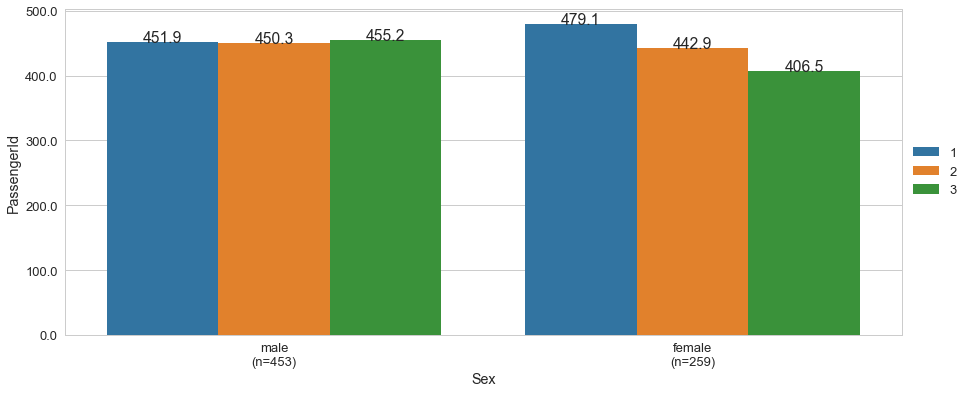

In [156]:
b.display()

In [167]:
c = Chart(df)

d = Chart(df)


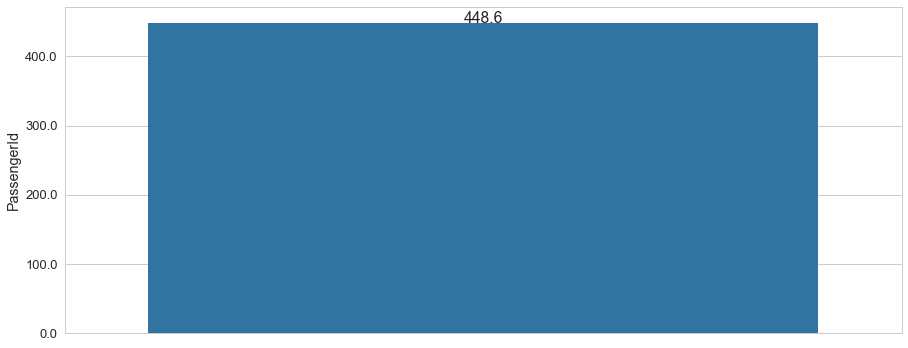

In [172]:
c.ax.figure
d.ax.figure